## Deps

In [ ]:
!conda install -n .conda ipykernel --update-deps --force-reinstall

: 

In [ ]:
!pip install torch tqdm scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from IPython.display import display, Markdown

import torch
from torch import nn

import sys

sys.path.append("../")

: 

## Dataset

In [2]:
ds = pd.read_csv("dataset.csv")

ds = ds[ds["target"] != 0]

ds["date"] = pd.to_datetime(ds["date"])
dates = ds["date"]
date_2_3 = dates.mean() + 2 / 3 * dates.std()
date_2_3, dates.max(), dates.min(), dates.mean(), dates.std()

(Timestamp('2013-02-24 14:21:30.714119313'),
 Timestamp('2013-05-19 00:00:00'),
 Timestamp('2012-08-18 00:00:00'),
 Timestamp('2013-01-02 12:07:47.759788544'),
 Timedelta('79 days 15:20:34.431496154'))

<Axes: >

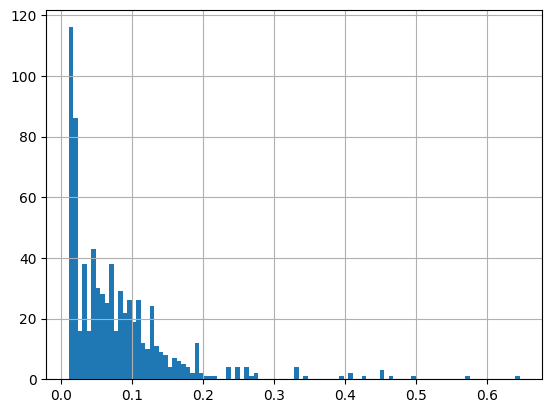

In [3]:
# For a sample player_1 in ds, plot target distribution
players_ocurrences = ds["player_1"].value_counts().sort_values(ascending=False)
sample_player = players_ocurrences.index[0]

sample_player_ds = ds[ds["player_1"] == sample_player]
sample_player_ds["target"].hist(bins=100)


(82550, 33448, 0.7116502008655322, 0.28834979913446784)

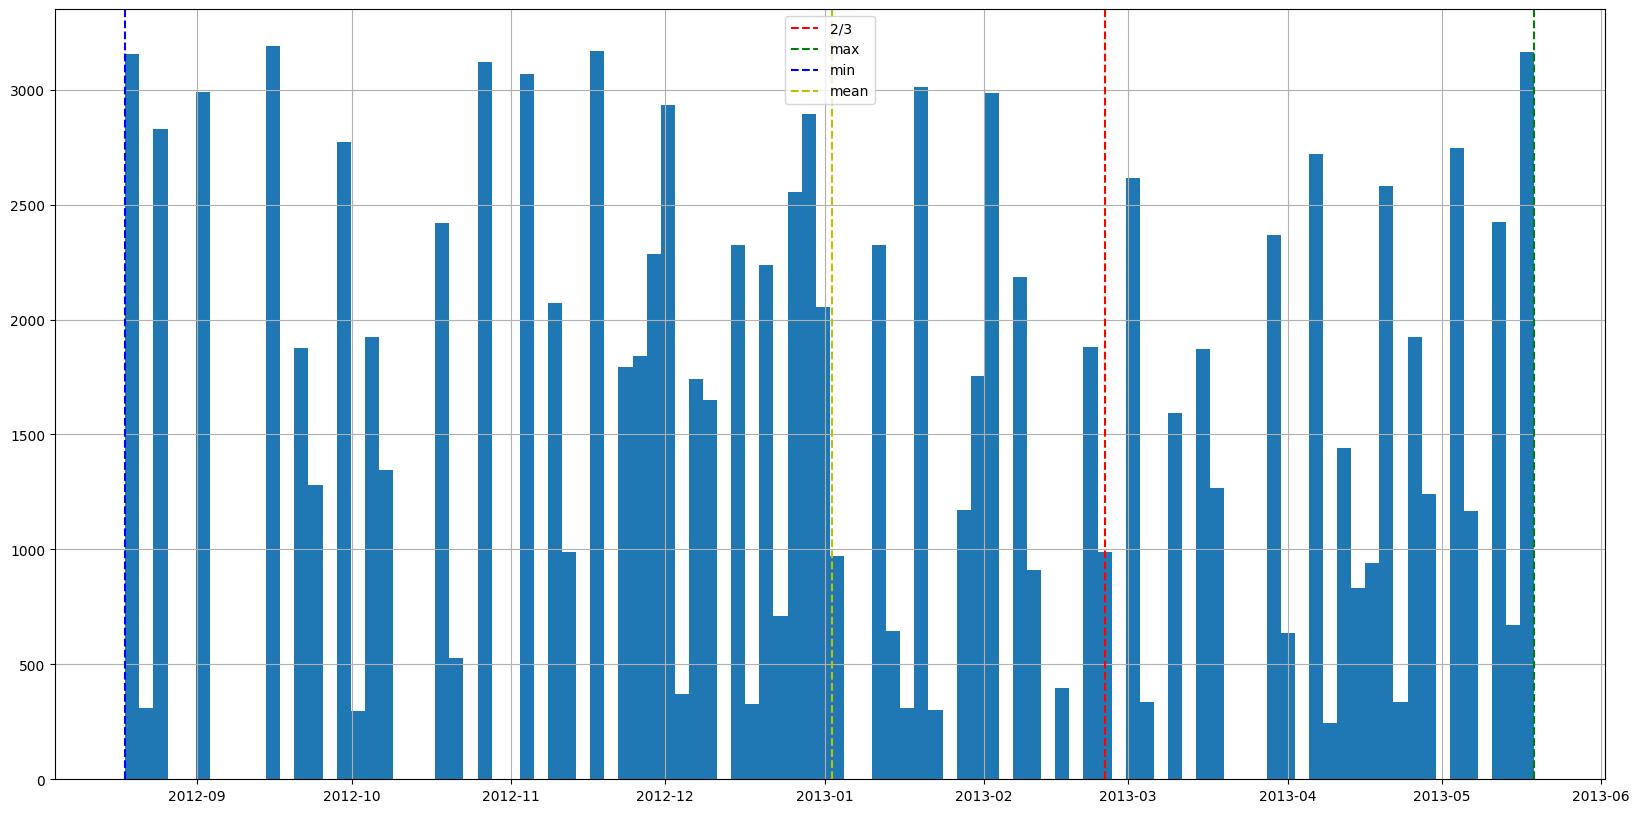

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
dates.hist(bins=100, ax=ax)

# Plot lines for date_2_3, dates.max(), dates.min(), dates.mean()
ax.axvline(date_2_3, color="r", linestyle="--", label="2/3")
ax.axvline(dates.max(), color="g", linestyle="--", label="max")
ax.axvline(dates.min(), color="b", linestyle="--", label="min")
ax.axvline(dates.mean(), color="y", linestyle="--", label="mean")

ax.legend()

left_c = ds[ds["date"] < date_2_3].shape[0]
right_c = ds[ds["date"] >= date_2_3].shape[0]

left_c, right_c, left_c / (right_c + left_c), right_c / (right_c + left_c)

In [5]:
# Select pairs of player_1 and player_2 that appear in the dataset
# Keep them in a test set

pairs = ds[["player_1", "player_2"]].drop_duplicates()
sample_pairs = pairs.sample(100)

test = ds[
    ds["player_1"].isin(sample_pairs["player_1"])
    & ds["player_2"].isin(sample_pairs["player_2"])
]
train = ds[
    ~ds["player_1"].isin(sample_pairs["player_1"])
    | ~ds["player_2"].isin(sample_pairs["player_2"])
    | ~ds["player_1"].isin(sample_pairs["player_2"])
    | ~ds["player_2"].isin(sample_pairs["player_1"])
]

train_left = train[train["date"] < date_2_3]
test_right = test[test["date"] >= date_2_3]

In [6]:
X_train = train_left.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_train = train_left["target"]

X_test = test_right.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_test = test_right["target"]

## Model

In [7]:

device = "cpu"
print(f"Using {device} device")


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        print(x.shape)
        logits = self.linear_relu_stack(x)
        print(logits)
        return logits

model = NeuralNetwork()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packag

Using cpu device


In [8]:
inputs = torch.tensor(X_train.loc[0])
labels = torch.tensor(y_train.loc[0])

inputs, labels

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_56972/1682424614.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(X_train.loc[0])


(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor(0.0806))

In [9]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def train(X_train, y_train, model, loss_fn, optimizer, epochs):
    iterator = tqdm(range(epochs))
    for t in iterator:
        for i, row in X_train.iterrows():
            inputs = torch.tensor(row.values)
            labels = torch.tensor(y_train.loc[i])

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # print(f"Epoch {t}, Loss: {loss.item()}")
        iterator.set_postfix(
            {"Loss": loss.item(), "Epoch": t, "Score": model(inputs).item()}
        )

In [10]:
# Train the model
train(X_train, y_train, model, loss_fn, optimizer, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Evaluate the model
y_pred = []

for i, row in X_test.iterrows():
    inputs = torch.tensor(row.values)
    y_pred.append(model(inputs).item())

y_pred = np.array(y_pred)

sc = model(inputs).item()
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_test, y_pred)

# Plot regression line
reg = LinearRegression().fit(np.array(y_test).reshape(-1, 1), y_pred)
y_pred_line = reg.predict(np.array(y_test).reshape(-1, 1))
q_slope = reg.coef_[0]
q_intercept = reg.intercept_

# Dibujar la línea de regresión
ax.plot(
    y_test,
    y_pred_line,
    color="red",
    label=f"Línea de regresión \n (y={q_slope:.2f}x + {q_intercept:.2f})",
)

ax.legend()